In [2]:
import numpy as np
import pandas as pd
from math import *
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import mean_absolute_error

# Задание

1. Рассчитать:<br>
– спектральную характеристику относительной фоточувствительности фотодиода (построить
общую характеристику и вклад отдельных областей структуры) <br>
– зависимость спектральной характеристики и фототока от обратного смещения;<br>
– зависимость спектральной характеристики и фототока в максимуме спектральной чувствительности от заданных параметров структуры;<br>
– зависимость напряжения шума фотодиода от заданного параметра при обратном смещении 5В;<br>
– предложить способ увеличения чувствительности в коротковолновой области спектра
(обосновать предложение расчетами)  
– объяснить полученные результаты;  
(Площадь – 1 см2, скорость поверхностной рекомбинации – 5·10^4
см/с).
<br>
2. Подобрать материал и нарисовать энергетическую диаграмму гетероперехода в рабочем
режиме для получения СИД с заданной длиной волны

Материал - Al0.5Ga0.5As  
х = 0.5  
Тип p^+n  
Концентрация в слаболегированной области n0 = 3'*10^16 см-3  
Глубина залегания перехода x = 0.25 мкм  
Время жизни t = 10^-7 с  
Параметр - Время жизни  
лямбда = 1.5 мкм  
Площадь S = 1 см2  
S = 5**10^4 см/с

## 0. Описание переменных

In [3]:
x = 0.5
Eg = 1.9+0.125*x+0.143*x**2
Nc = 2.5*10**19*(0.85+0.14*x)**1.5
Nv = 2.5*10**19*(0.48+0.31*x)**1.5
tay = 10**-7
x_pn = 0.25*10**-4
nn0 = 3*10**16
lam = 1.42*10**-4
S_pn = 1
S = 5*10**4
m0 = 9.1*10**-31
mh = 0.51 + 0.25*x*m0
me = 0.85 - 0.14*x*m0
ni = exp(-Eg/(2*0.026))*(Nc*Nv)**0.5
pn0 = (ni**2)/nn0
pp0 = nn0*10**2
np0 = ni**2/pp0
q = 1.6*10**-19
eps = 12.90-2.84*x
eps0 = 8.85*10**-14
Phi_potok = 10**15
R = 0.3

mu_n = -255 + 1160*x - 720*x**2
mu_p = 370 - 970*x + 740*x**2
D_n = 0.026*mu_n
D_p = 0.026*mu_p
L_n = sqrt(D_n*tay)
L_p = sqrt(D_p*tay)

phi = 0.026*log(pp0*nn0/ni**2)
W_opz = sqrt(2*eps*eps0*phi/(q*nn0))
W_opz_p = W_opz*nn0/pp0
W_opz_n = W_opz*(1-nn0/pp0)
W_b_p = x_pn - W_opz_p
W_b_n = 15*10**-4

In [4]:
D_p, D_n, L_p, L_n, pn0, np0, phi, W_opz, W_opz_p, W_opz_n, W_b_p

(1.8199999999999998,
 3.77,
 0.00042661458015403085,
 0.00061400325732035,
 3.8955125894076745e-12,
 3.895512589407674e-14,
 1.7892248349540163,
 2.7521329968897014e-05,
 2.7521329968897013e-07,
 2.7246116669208043e-05,
 2.472478670031103e-05)

x-rc = 0.03187

##  1.1 спектральную характеристику относительной фоточувствительности фотодиода   
(построить общую характеристику и вклад отдельных областей структуры)

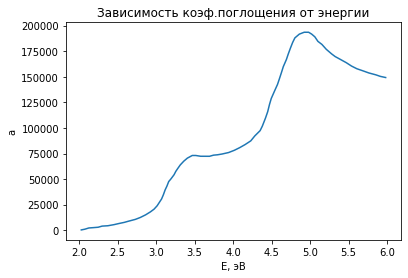

In [5]:
data = pd.read_excel('3.xlsx')
energy_graph = np.array(data['energy'])
alpha_graph = np.array(data['alpha'])
plt.plot(energy_graph, alpha_graph)
plt.title('Зависимость коэф.поглощения от энергии')
plt.ylabel('a')
plt.xlabel('E, эВ');

Средняя абсолютная ошибка = 2153.058993570036


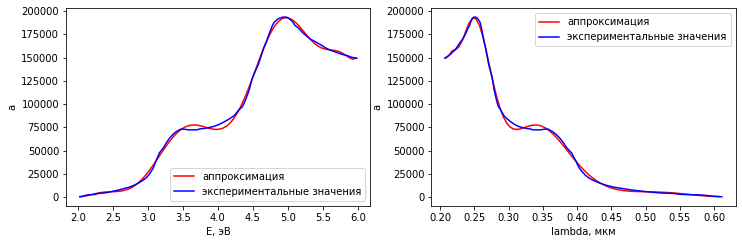

In [6]:
def alpha_energy(energy, res_x):
    a = 0
    for i in range(len(res_x[0])):
        a += res_x[0][i]*energy**i
    return a

def alpha(lambd, res_x):
    energy = 1.24/lambd
    a = 0
    for i in range(len(res_x[0])):
        a += res_x[0][i]*energy**i
    return a if a>0 else 0

n_polynom = 16

coefs = np.array([[x**i for i in range(n_polynom+1)] for x in energy_graph])
weights = np.linalg.lstsq(coefs, alpha_graph)
energy_test = np.arange(energy_graph.min(), energy_graph.max(), 0.05)
alpha_test = [alpha_energy(y, weights) for y in energy_test]

alpha_for_MAE = [alpha_energy(energy, weights) for energy in energy_graph]
print('Средняя абсолютная ошибка =', mean_absolute_error(alpha_for_MAE, alpha_graph))

plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.plot(energy_test, alpha_test, color='red', label='аппроксимация')
plt.plot(energy_graph, alpha_graph, color='blue', label='экспериментальные значения')
plt.xlabel('E, эВ')
plt.ylabel('a')
plt.legend();


plt.subplot(2,2,2)
lambd_max = 1.24/energy_graph.min()
lambd_min = 1.24/energy_graph.max()
lambdas = np.arange(lambd_min, lambd_max, 0.005)
alpha_lambdas_test = np.array([alpha(lam, weights) for lam in lambdas])
lambdas_graph = np.array([1.24/e for e in energy_graph])
plt.plot(lambdas, alpha_lambdas_test, color='red', label='аппроксимация')
plt.plot(lambdas_graph, alpha_graph, color='blue', label='экспериментальные значения')
plt.xlabel('lambda, мкм')
plt.ylabel('a')
plt.legend();

### Введение функций для расчета составляющих токов в разных областях п/п

In [7]:
def I_p_Phi(W_b_n, L_p, s_p, D_p, lambd, W_opz, S_pn=1, q=1.6*10**-19, Phi_potok=10**15, R=0.3):
    a = W_b_n/L_p
    b = s_p*L_p/D_p
    al = alpha(lambd, weights)
    first = ((q*Phi_potok*(1-R)*al*L_p)/(al**2*L_p**2-1))
    second = (b + al*L_p) - exp(-al*W_b_n)*(b*cosh(a) + sinh(a))
    third = (b*sinh(a)+cosh(a))
    forth = al*L_p*exp(-al*W_b_n)
    return first*(second/third - forth)

def I_n_Phi(W_b_p, W_b_n, L_n, s_n, D_n, lambd, W_opz, S_pn=1, q=1.6*10**-19, Phi_potok=10**15, R=0.3):
    a = W_b_p/L_n
    b = s_n*L_n/D_n
    al = alpha(lambd, weights)
    c = al*L_n
    first = (q*Phi_potok*(1-R)*c/(c**2-1))
    second = exp(-al*(W_b_n+W_opz))
    third = (al*L_n - ((b*(cosh(a)-exp(-al*W_b_p))+sinh(a)+c*exp(-al*W_b_p))/
                      (b*sinh(a)+cosh(a))))
    return first*second*third

def I_opz_Phi(lambd, x_j, W_opz, S_pn=1, q=1.6*10**-19, Phi_potok=10**15, R=0.3):
    first = S_pn*(q*Phi_potok*(1-R)*exp(-alpha(lambd, weights)*x_j))
    second = 1 - exp(-alpha(lambd, weights)*W_opz)
    return first*second

def quant_eff(j_sum, R=0.3 ,S_pn=1, q=1.6*10**-19, Phi_potok=10**15):
    return j_sum/(q*Phi_potok*(1-R))

def photosense(quant_eff, lambd, q=1.6*10**-19):
    return quant_eff*lambd/1.24

def photosense1(j_sum):
    return j_sum/(1.6*10**-19*10**15*1)

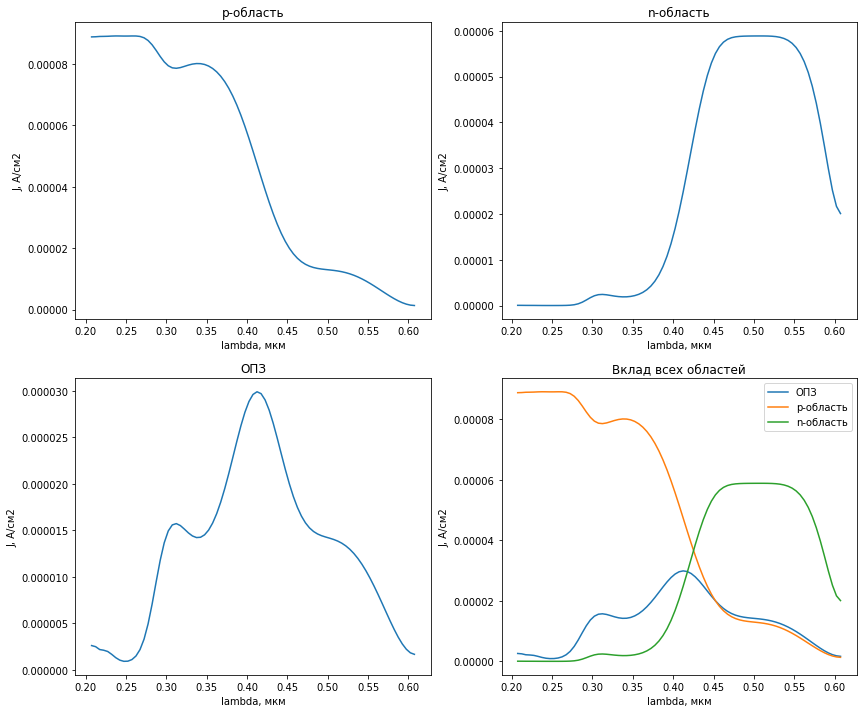

In [8]:
photosenses = np.empty(len(lambdas))
photosenses_n = np.empty(len(lambdas))
photosenses_p = np.empty(len(lambdas))
photosenses_opz = np.empty(len(lambdas))
I_n_all = np.empty(len(lambdas))
I_p_all = np.empty(len(lambdas))
I_opz_all = np.empty(len(lambdas))
for i in range(len(lambdas)):
    I_n = I_p_Phi(W_b_p, L_n, S, D_n, lambdas[i], W_opz)
    I_p = I_n_Phi(W_b_n, W_b_p, L_p, S, D_p, lambdas[i], W_opz)
    I_opz = I_opz_Phi(lambdas[i], x_pn, W_opz)
    I_sum = I_n + I_p + I_opz
    n_quant = quant_eff(I_sum)
    I_n_all[i] = I_n
    I_p_all[i] = I_p
    I_opz_all[i] = I_opz
    photosenses[i] = photosense(n_quant, lambdas[i])
    photosenses_n[i] = photosense(quant_eff(I_n), lambdas[i])
    photosenses_p[i] = photosense(quant_eff(I_p), lambdas[i])
    photosenses_opz[i] = photosense(quant_eff(I_opz), lambdas[i])

plt.figure(figsize=(14, 12))
plt.subplot(2,2,1)
plt.plot(lambdas, I_n_all)
plt.title('p-область')
plt.xlabel('lambda, мкм')
plt.ylabel('J, А/см2')
plt.subplot(2,2,2)
plt.plot(lambdas, I_p_all)
plt.title('n-область')
plt.xlabel('lambda, мкм')
plt.ylabel('J, А/см2')
plt.subplot(2,2,3)
plt.plot(lambdas, I_opz_all)
plt.title('ОПЗ')
plt.xlabel('lambda, мкм')
plt.ylabel('J, А/см2')
plt.subplot(2,2,4)
plt.plot(lambdas, I_opz_all, label='ОПЗ')
plt.plot(lambdas, I_n_all, label='p-область')
plt.plot(lambdas, I_p_all, label='n-область')
plt.title('Вклад всех областей')
plt.xlabel('lambda, мкм')
plt.ylabel('J, А/см2')
plt.legend();

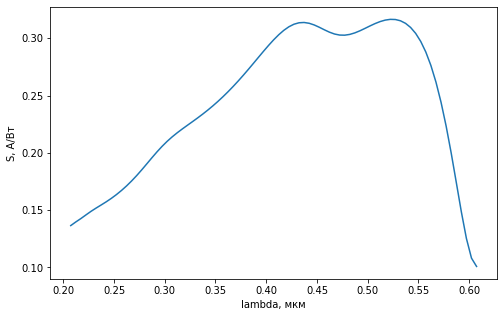

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(lambdas, photosenses)
plt.xlabel('lambda, мкм')
plt.ylabel('S, А/Вт');

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()

In [12]:
new_photosenses = [ph/photosenses.max() for ph in photosenses]

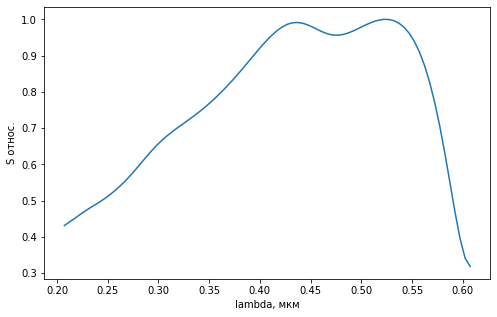

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(lambdas, new_photosenses)
plt.xlabel('lambda, мкм')
plt.ylabel('S относ.');

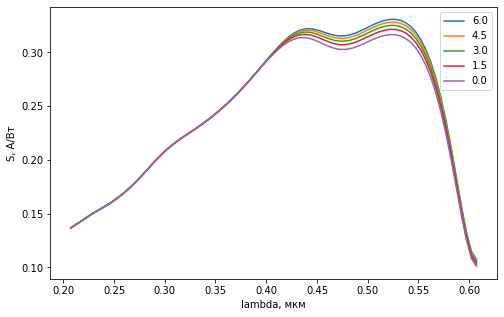

In [15]:
U_out = np.arange(6, -1, -1.5)
I_all = np.empty(len(lambdas))
plt.figure(figsize=(8, 5))
for U in U_out:
    W_opz = sqrt(2*eps*eps0*(phi+U)/(q*nn0))
    W_opz_p = W_opz*nn0/pp0
    W_opz_n = W_opz*(1-nn0/pp0)
    W_b_p = x_pn - W_opz_p
    W_b_n = 15*10**-4
    for i in range(len(lambdas)):
        I_n = I_p_Phi(W_b_p, L_n, S, D_n, lambdas[i], W_opz)
        I_p = I_n_Phi(W_b_n, W_b_p, L_p, S, D_p, lambdas[i], W_opz)
        I_opz = I_opz_Phi(lambdas[i], x_pn, W_opz)
        I_sum = I_n + I_p + I_opz
        n_quant = quant_eff(I_sum)
        #print(I_n, I_p, I_opz, I_sum, n_quant)
        I_n_all[i] = I_n
        I_p_all[i] = I_p
        I_opz_all[i] = I_opz
        I_all[i] = I_n + I_p + I_opz
        photosenses[i] = photosense(n_quant, lambdas[i])
    plt.plot(lambdas, photosenses, label=U)
plt.xlabel('lambda, мкм')
plt.ylabel('S, А/Вт');
plt.legend();

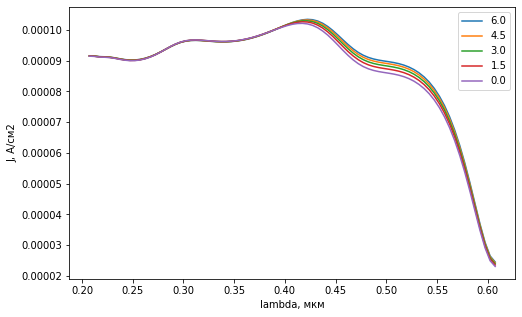

In [16]:
U_out = np.arange(6, -1, -1.5)
I_all = np.empty(len(lambdas))
plt.figure(figsize=(8, 5))
for U in U_out:
    W_opz = sqrt(2*eps*eps0*(phi+U)/(q*nn0))
    W_opz_p = W_opz*nn0/pp0
    W_opz_n = W_opz*(1-nn0/pp0)
    W_b_p = x_pn - W_opz_p
    W_b_n = 15*10**-4
    for i in range(len(lambdas)):
        I_n = I_p_Phi(W_b_p, L_n, S, D_n, lambdas[i], W_opz)
        I_p = I_n_Phi(W_b_n, W_b_p, L_p, S, D_p, lambdas[i], W_opz)
        I_opz = I_opz_Phi(lambdas[i], x_pn, W_opz)
        I_sum = I_n + I_p + I_opz
        n_quant = quant_eff(I_sum)
        #print(I_n, I_p, I_opz, I_sum, n_quant)
        I_n_all[i] = I_n
        I_p_all[i] = I_p
        I_opz_all[i] = I_opz
        I_all[i] = I_n + I_p + I_opz
        photosenses[i] = photosense(n_quant, lambdas[i])
    plt.plot(lambdas, I_all, label=U)
plt.xlabel('lambda, мкм')
plt.ylabel('J, А/см2');
plt.legend();

In [ ]:
max_lambda

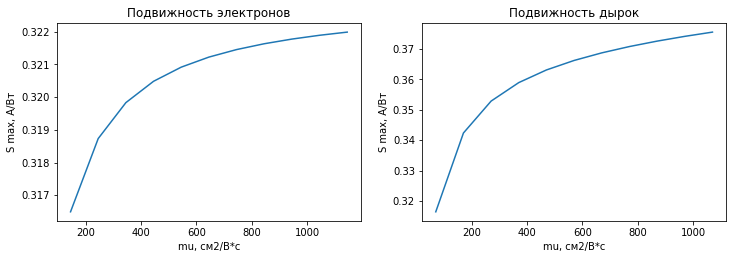

In [17]:
i_max = 0
for i in range(len(photosenses)):
    if photosenses[i] == photosenses.max():
        i_max = i
max_lambda = lambdas[i_max]
mu_n_arr = np.arange(1000+mu_n, mu_n-1, -100)
mu_p_arr = np.arange(1000+mu_p, mu_p-1, -100)
photosense_electrons = np.empty(len(mu_n_arr))
photosense_holes = np.empty(len(mu_p_arr))

plt.figure(figsize=(12, 8))
for i in range(len(mu_n_arr)):
    D_n = 0.026*mu_n_arr[i]
    L_n = sqrt(D_n*tay)
    I_n = I_p_Phi(W_b_p, L_n, S, D_n, max_lambda, W_opz)
    I_p = I_n_Phi(W_b_n, W_b_p, L_p, S, D_p, max_lambda, W_opz)
    I_opz = I_opz_Phi(max_lambda, x_pn, W_opz)
    I_sum = I_n + I_p + I_opz
    n_quant = quant_eff(I_sum)
    #print(I_n, I_p, I_opz, I_sum, n_quant)
    I_n_all[i] = I_n
    I_p_all[i] = I_p
    I_opz_all[i] = I_opz
    photosense_electrons[i] = photosense(n_quant, max_lambda)

for i in range(len(mu_p_arr)):
    D_p = 0.026*mu_p_arr[i]
    L_p = sqrt(D_p*tay)
    I_n = I_p_Phi(W_b_p, L_n, S, D_n, max_lambda, W_opz)
    I_p = I_n_Phi(W_b_n, W_b_p, L_p, S, D_p, max_lambda, W_opz)
    I_opz = I_opz_Phi(max_lambda, x_pn, W_opz)
    I_sum = I_n + I_p + I_opz
    n_quant = quant_eff(I_sum)
    #print(I_n, I_p, I_opz, I_sum, n_quant)
    I_n_all[i] = I_n
    I_p_all[i] = I_p
    I_opz_all[i] = I_opz
    photosense_holes[i] = photosense(n_quant, max_lambda)
    
plt.subplot(2,2,1)
plt.title('Подвижность электронов')
plt.xlabel('mu, см2/В*с')
plt.ylabel('S max, А/Вт');
plt.plot(mu_n_arr, photosense_electrons);
plt.subplot(2,2,2)
plt.title('Подвижность дырок')
plt.xlabel('mu, см2/В*с')
plt.ylabel('S max, А/Вт');
plt.plot(mu_p_arr, photosense_holes);

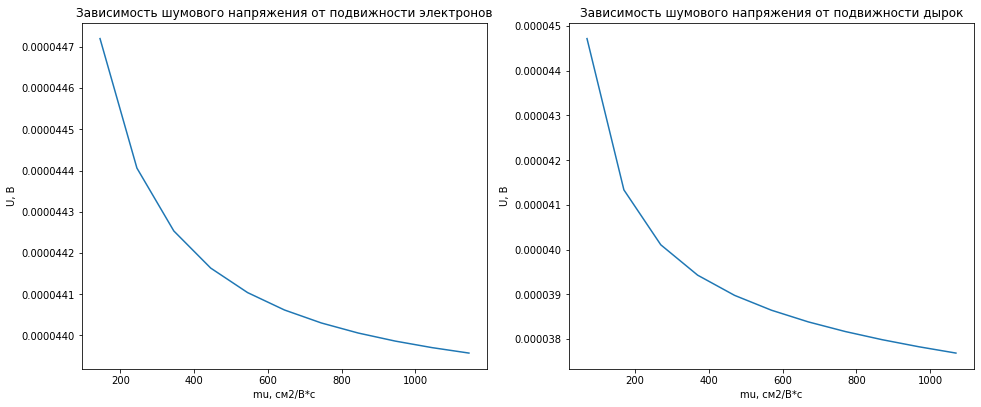

In [18]:
U_shum_electrons = np.empty(len(mu_n_arr))
U_shum_holes = np.empty(len(mu_p_arr))
U_vnesh = 5
for i in range(len(mu_n_arr)):
    D_n = 0.026*mu_n_arr[i]
    L_n = sqrt(D_n*tay)
    I_rec = q*ni*W_opz*S/(tay)
    I_n = I_p_Phi(W_b_p, L_n, S, D_n, max_lambda, W_opz)
    I_p = I_n_Phi(W_b_n, W_b_p, L_p, S, D_p, max_lambda, W_opz)
    I_opz = I_opz_Phi(max_lambda, x_pn, W_opz)
    I_sum = I_n + I_p + I_opz
    R_diff = U_vnesh/I_sum
    U_shum_electrons[i] = R_diff*I_rec


for i in range(len(mu_p_arr)):
    D_p = 0.026*mu_p_arr[i]
    L_p = sqrt(D_p*tay)
    I_rec = q*ni*W_opz*S/(tay)
    I_n = I_p_Phi(W_b_p, L_n, S, D_n, max_lambda, W_opz)
    I_p = I_n_Phi(W_b_n, W_b_p, L_p, S, D_p, max_lambda, W_opz)
    I_opz = I_opz_Phi(max_lambda, x_pn, W_opz)
    I_sum = I_n + I_p + I_opz
    R_diff = U_vnesh/I_sum
    U_shum_holes[i] = R_diff*I_rec


plt.figure(figsize=(16, 14))
plt.subplot(2,2,1)
plt.title('Зависимость шумового напряжения от подвижности электронов')
plt.xlabel('mu, см2/В*с')
plt.ylabel('U, B');
plt.plot(mu_n_arr, U_shum_electrons);
plt.subplot(2,2,2)
plt.title('Зависимость шумового напряжения от подвижности дырок')
plt.xlabel('mu, см2/В*с')
plt.ylabel('U, B');
plt.plot(mu_p_arr, U_shum_holes);

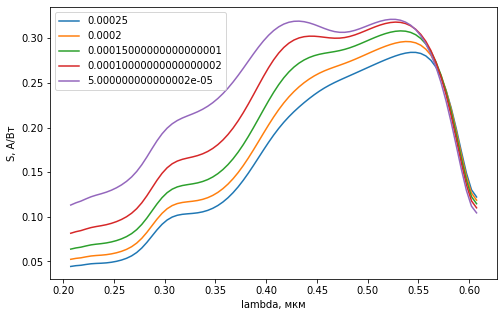

In [24]:
x_js = np.arange(2.5e-4, x_pn, -0.5e-4)
plt.figure(figsize=(8, 5))
for x_j in x_js:
    W_b_p = x_j - W_opz_p
    W_b_n = 15*10**-4
    for i in range(len(lambdas)):
        I_n = I_p_Phi(W_b_p, L_n, S, D_n, lambdas[i], W_opz)
        I_p = I_n_Phi(W_b_n, W_b_p, L_p, S, D_p, lambdas[i], W_opz)
        I_opz = I_opz_Phi(lambdas[i], x_pn, W_opz)
        I_sum = I_n + I_p + I_opz
        n_quant = quant_eff(I_sum)
        photosenses[i] = photosense(n_quant, lambdas[i])
    plt.plot(lambdas, photosenses, label=x_j)
    
plt.xlabel('lambda, мкм')
plt.ylabel('S, А/Вт')
plt.legend();

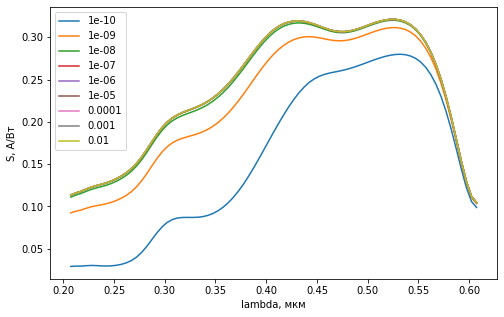

In [25]:
tay_ns = np.array([10**g for g in range(-10, -1, 1)])
plt.figure(figsize=(8, 5))
L_ns = [sqrt(D_n*tay) for tay in tay_ns]
for j in range(len(tay_ns)):
    for i in range(len(lambdas)):
        #print(L_ns[j])
        I_n = I_p_Phi(W_b_p, L_ns[j], S, D_n, lambdas[i], W_opz)
        I_p = I_n_Phi(W_b_n, W_b_p, L_p, S, D_p, lambdas[i], W_opz)
        I_opz = I_opz_Phi(lambdas[i], x_pn, W_opz)
        I_sum = I_n + I_p + I_opz
        n_quant = quant_eff(I_sum)
        photosenses[i] = photosense(n_quant, lambdas[i])
    plt.plot(lambdas, photosenses, label=tay_ns[j])
plt.xlabel('lambda, мкм')
plt.ylabel('S, А/Вт')
plt.legend();

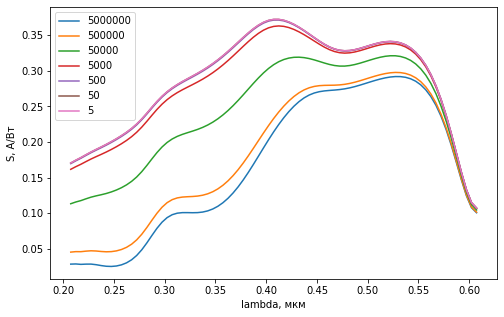

In [26]:
S_s = np.array([5*10**g for g in range(6, -1, -1)])
plt.figure(figsize=(8, 5))
for j in range(len(S_s)):
    for i in range(len(lambdas)):
        I_n = I_p_Phi(W_b_p, L_n, S_s[j], D_n, lambdas[i], W_opz)
        I_p = I_n_Phi(W_b_n, W_b_p, L_p, S, D_p, lambdas[i], W_opz)
        I_opz = I_opz_Phi(lambdas[i], x_pn, W_opz)
        I_sum = I_n + I_p + I_opz
        n_quant = quant_eff(I_sum)
        photosenses[i] = photosense(n_quant, lambdas[i])
    plt.plot(lambdas, photosenses, label=S_s[j])
plt.xlabel('lambda, мкм')
plt.ylabel('S, А/Вт')
plt.legend();

# 2. Построение зонной диаграммы

In [27]:
lambd = 1.42
Eg_new_material = 1.24/lambd

In [28]:
ys = np.arange(0, 1, 0.005)
for y in ys:
    if 0.87 < 0.36+0.63*y+0.43*y**2 and 0.36+0.63*y+0.43*y**2 < 0.875:
        x_GaInAs = y

In [39]:
Eg_new_material

0.8732394366197184

In [29]:
x_GaInAs

0.58

In [40]:
el_aff_GIA, el_aff_AGA, Nc_GIA, Nv_GIA, ni_GIA

(4.4186000000000005,
 3.5700000000000003,
 944450203485845.6,
 5.842603667154595e+17,
 1196070582.845274)

In [32]:
el_aff_GIA = 4.9-0.83*x_GaInAs
el_aff_AGA = 3.64-0.14*x 
Nc_GIA = 4.82 * 10**15 * (0.023+0.037*x+0.003*x**2)**3/2 *300**(3/2)
Nv_GIA = 4.82 * 10**15 * (0.41-0.1*x)**3/2 * 300**(3/2)
ni_GIA = ((Nc_GIA*Nv_GIA)**0.5)*exp(-Eg_new_material/(2*0.026))

In [57]:
Na_GIA = 10**16
Nd_AGA = 10**18
fermi_GIA = 0.026*log(Nv_GIA/Na_GIA)
fermi_AGA = 0.026*log(Nc/Nd_AGA)
rab_vih_GIA = el_aff_GIA + Eg_new_material-fermi_GIA
rab_vih_AGA = el_aff_AGA + fermi_AGA
phi_hetero = rab_vih_GIA - rab_vih_AGA
eps1 = eps
eps2 = 15.1-2.87*x+0.67*x**2
U = 0
x_AGA = ((2*Na_GIA*eps1*eps2*(phi_hetero - phi_hetero)*eps0)/(q*Nd_AGA*(eps1*Nd_AGA + eps2*Na_GIA)))**0.5
x_GIA = ((2*Nd_AGA*eps1*eps2*(phi_hetero - phi_hetero))*eps0/(q*Na_GIA*(eps1*Nd_AGA + eps2*Na_GIA)))**0.5
x_AGA + x_GIA

0.0

In [56]:
print(fermi_GIA, fermi_AGA)
print(el_aff_GIA, el_aff_AGA)
print(rab_vih_GIA, rab_vih_AGA, phi_hetero, eps2)
print(x_AGA, x_GIA)

0.10576180222131876 0.08043888869795023
4.4186000000000005 3.5700000000000003
5.1860776343984 3.6504388886979506 1.535638745700449 13.8325
4.818597994476023e-07 4.818597994476023e-05


In [35]:
otnosh = Na_GIA*eps2/(Nd_AGA*eps1)

In [36]:
otnosh

0.012049216027874565

In [44]:
#Vbi1 = Vbi2*0.012
#Vbi1 + Vbi2 = Vbi
#Vbi2*0.012 + Vbi2 = Vbi
#Vbi2 = Vbi/1.012
Vbi2 = phi_hetero/1.012
Vbi1 = Vbi2*0.012

In [47]:
Vbi1, Vbi2

(0.018209155087357102, 1.517429590613092)

In [54]:
Na_GIA = 10**16
Nd_AGA = 10**18
fermi_GIA = 0.026*log(Nv_GIA/Na_GIA)
fermi_AGA = 0.026*log(Nc/Nd_AGA)
rab_vih_GIA = el_aff_GIA + Eg_new_material-fermi_GIA
rab_vih_AGA = el_aff_AGA + fermi_AGA
phi_hetero = rab_vih_GIA - rab_vih_AGA
eps1 = eps
eps2 = 15.1-2.87*x+0.67*x**2
U = 1
x_AGA = ((2*Na_GIA*eps1*eps2*(phi_hetero - 0)*eps0)/(q*Nd_AGA*(eps1*Nd_AGA + eps2*Na_GIA)))**0.5
x_GIA = ((2*Nd_AGA*eps1*eps2*(phi_hetero - 0))*eps0/(q*Na_GIA*(eps1*Nd_AGA + eps2*Na_GIA)))**0.5
print(fermi_GIA, fermi_AGA)
print(el_aff_GIA, el_aff_AGA)
print(x_GIA, x_AGA)

0.10576180222131876 0.08043888869795023
4.4186000000000005 3.5700000000000003
4.818597994476023e-05 4.818597994476023e-07


In [46]:
J

NameError: name 'J' is not defined

In [ ]:
B = 3*10**-10
delta_Ec = 0.7*Eg
W_DH = 0.25*10**-4
J = ((4*Nc/(3*sqrt(pi)))**2)*(delta_Ec/0.026)**3*q*B*W_DH
n=3.3-0.53*x+0.09*x**2
phi_c = asin(1.5/n)
otnosh = 0.5*(1-cos(phi_c))
print(otnosh)

In [ ]:
lam = 1.24/Eg
print(lam)

In [ ]:
lam*3/4

Al203 t = 0.35

In [ ]:
lam = 1.24/Eg
t = np.arange(0.15, 0.36, 0.003)
for each in t:
    epsi = ((3*lam/(4*each))**2)
    if epsi > 1.43 and epsi < 2.5:
        print(epsi, each)


In [ ]:
mu_n

In [ ]:
t = 1*10**-4
N_leg = 10**16
neid = 2
J0 = 1*10**-3
ro = 1/(q*N_leg*mu_n)
print(ro)

In [ ]:
Ls = sqrt((t*neid*0.026)/(ro*J0))
print('Ls =',Ls, 'см или ИДЕМ КУРИТЬ?')

In [ ]:
otnosh_tok = e
resh = np.arange(0, 1, 0.00001)
for find_x in resh:
    rasschet = ((find_x/Ls + sqrt(2))**2)/2
    if rasschet < e+0.001 and rasschet > e-0.001:
        print(find_x, rasschet, e)